# Homework 11.4 - Coding

This is the coding portion of the homework assignment for Section 11.4

In [37]:
from typing import Callable
import numpy as np
from matplotlib import pyplot as plt
from time import perf_counter
# from jax import grad
# from jax import numpy as jnp

EPSILON_MACHINE = np.finfo(float).eps 

In [38]:
def convergence_plots(
    h_vals: np.ndarray,
    times: list[float],
    errors: list[float],
    method: str,
    err_type: str
):
    """A helper function so you don't have to write a bunch of tedious plotting code."""
    # Error analysis
    if np.allclose(np.min(errors), 0):
        # If there are any zero errors 
        y_diff = np.log(errors[1]) - np.log(errors[0])
        x_diff = np.log(h_vals[1]) - np.log(h_vals[0])
        convergence_rate = y_diff / x_diff
    else:
        log_errors_arr = np.log(np.array(errors))
        log_step_sizes = np.log(h_vals)
        convergence_rate, _ = np.polyfit(log_step_sizes, log_errors_arr, 1)
    print(f"Estimated Convergence Rate for {method}: {convergence_rate:.4f}")

    # Time plot
    plt.semilogx(h_vals, times, '.-')
    plt.suptitle(f"Computation Times for {method}")
    plt.xlabel("Step Size $h$")
    plt.ylabel("Computation Time (s)")
    plt.show() 

    # Error plot
    plt.semilogx(h_vals, errors, '.-')
    plt.suptitle(f"{err_type} Errors for {method}")
    plt.xlabel("Step Size $h$")
    plt.ylabel(f"{err_type} Error")
    plt.show() 

## Problem 11.16

### Part (i) 

Complete the function `jac_forward()` which accepts a callable function $f: \mathbb{R}^n \to \mathbb{R}^m$ ($n, m \geq 2$), a point $\mathbf{x} \in \mathbb{R}^n$, and a step size $h$ (defaulting to $h = 2 \sqrt{\varepsilon_{\text{machine}}}$), and computes the Jacobian matrix

$$Df(\mathbf{x}) = \begin{bmatrix} \frac{\partial f_1}{\partial x_1}(\mathbf{x}) & \frac{\partial f_1}{\partial x_2}(\mathbf{x}) & \cdots & \frac{\partial f_1}{\partial x_n}(\mathbf{x}) \\ \frac{\partial f_2}{\partial x_1}(\mathbf{x}) & \frac{\partial f_2}{\partial x_2}(\mathbf{x}) & \cdots & \frac{\partial f_2}{\partial x_n}(\mathbf{x}) \\ \vdots & \vdots & \ddots & \vdots \\ \frac{\partial f_m}{\partial x_1}(\mathbf{x}) & \frac{\partial f_m}{\partial x_2}(\mathbf{x}) & \cdots & \frac{\partial f_m}{\partial x_n}(\mathbf{x}) \\ \end{bmatrix} \in \mathbb{R}^{m \times n}$$

using forward differences.

In [39]:
def jac_forward(
    f: Callable[[np.ndarray], np.ndarray],
    x: np.ndarray,
    h: float = 2 * np.sqrt(EPSILON_MACHINE)
) -> np.ndarray:
    """Computes the mxn Jacobian matrix of a function f 
    at a given point x in R^n using forward differences
    with a given step size h
    
    Args:
        f (Callable[[np.ndarray], np.ndarray]) - A callable function
            that takes in n-dimensional points and returns 
            m-dimensional points (n, m >= 2). This is the 
            function to find the Jacobian matrix of.
        x (np.ndarray) - An n-dimensional point where we'd
            like to find the Jacobian matrix at 
        h (float) - The step size to use in the forward
            finite-difference scheme

    Returns:
        np.ndarray - The mxn Jacobian matrix Df
    """
    n = len(x)
    m = len(f(x))

    res = np.zeros((m, n))

    fx = f(x)  # cache

    for x_i in range(n):
        x_plus_h = x.copy()
        x_plus_h[x_i] += h
        res[:, x_i] = (f(x_plus_h) - fx) / h

    return res

    # for f_i in range(m):
    #     for x_i in range(n):
    #         x_plus_h = x + np.eye(n)[x_i]*h
    #         res[f_i, x_i] = (f(x_plus_h) - f(x))[f_i] / h

    # return res


### Part (ii)

Complete the function `jac_actual()`, which returns the exact Jacobian matrix of 
$$f(x,y) = \begin{bmatrix} \frac{x}{x + 2 + y^2} \\ \frac{y}{x^2 + y^2} \end{bmatrix}$$
at a given two-dimensional point $\mathbf{x} = (x,y)$, using a formula you get by computing the Jacobian matrix by hand.

In [40]:
def jac_actual(x: np.ndarray) -> np.ndarray:
    """Returns the Jacobian matrix of the given f(x,y)
    at a provided point x.
    
    Args:
        np.ndarray - A 2-element, 1D array representing
            the point (x,y) to evaluate the Jacobian at 

    Returns:
        np.ndarray - The 2x2 Jacobian matrix of f,
            evaluated at this point x = (x,y)
    """
    x_pt = x[0]
    y_pt = x[1]

    J = np.array([
        [(2 + y_pt**2) / (x_pt + 2 + y_pt**2)**2, (-2 * y_pt * x_pt) / (x_pt + 2 + y_pt **2)**2],
        [(-2 * y_pt * x_pt) / (x_pt**2 + y_pt **2)**2, (x_pt**2 - y_pt**2) / (x_pt**2 + y_pt **2)**2]
    ])

    return J



Now, run the following cell to evaluate this exact Jacobian expression numerically at the point $\mathbf{x} = (2,3)$.

In [46]:
# ------------- DO NOT EDIT. JUST RUN ----------------- # 
x = np.array([2., 3.])
print("ACTUAL JACOBIAN VALUE AT (2,3):")
print(jac_actual(x))

ACTUAL JACOBIAN VALUE AT (2,3):
[[ 0.06508876 -0.07100592]
 [-0.07100592 -0.0295858 ]]


### Parts (iii)-(iv)

For each step size $h = 2^{-k}$ (for $k = 2, 3, \ldots, 53$). (listed in the provided array `h_vals`):

1. Time the following: Use your function `jac_forward()` from part (i) to approximate the 
   Jacobian matrix of the same function as part (ii)

   $$f(x,y) = \begin{bmatrix} \frac{x}{x + 2 + y^2} \\ \frac{y}{x^2 + y^2} \end{bmatrix}$$ 
   
   at the point $\mathbf{x} = (2,3)$. Use the function `time.perf_counter()` to measure the start/end times. Store the elapsed time in the list `times` provided to you.

2. Compute the Frobenius-norm error between your approximation from step (1) and the exact solution from `jac_actual()`. Store the error in the list `errors` provided to you.


The provided code will help you plot both your time and your error, analyze convergence, and display which step size $h$ was optimal in terms of both time and accuracy.

Best step size h for time: 2^-(-23.0)
Best step size h for error: 2^-(-25.0)
Estimated Convergence Rate for Forward Difference Jacobians: 0.9696


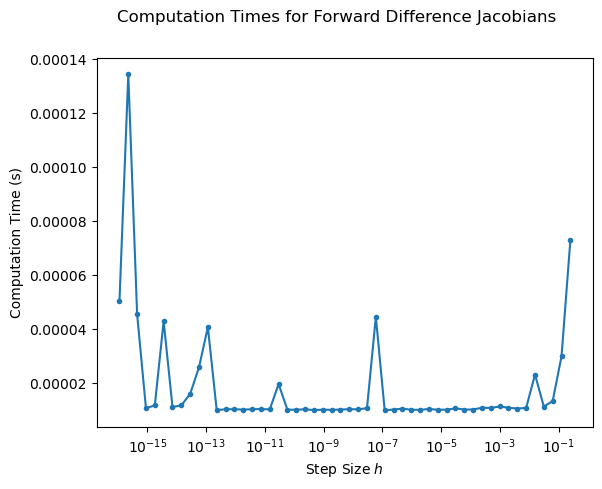

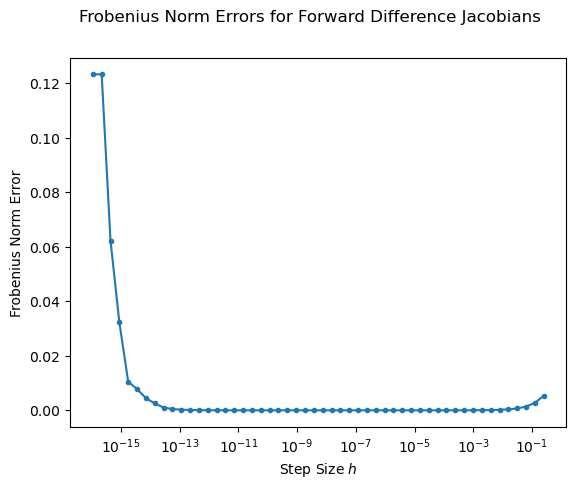

In [49]:
h_vals = 1 / (2 ** np.arange(2, 54))    # Step sizes to use 
x = np.array([2., 3.])                  # Input point to evaluate Jacobian at 
f = lambda x: np.array([
    x[0] / (x[0] + 2 + x[1]**2),
    x[1] / (x[0]**2 + x[1]**2)
])                                      # Function of interest 
exact_jacobian = jac_actual(x)          # Exact value of Jacobian of f (for error analysis)

times = [] 
errors = []
for h in h_vals:
    start = perf_counter()
    forward = jac_forward(f, x, h)
    times.append(perf_counter() - start)
    errors.append(np.linalg.norm(forward - exact_jacobian))




# Compute exponent of 2 for best step size for time/error
h_best_time = np.log2(h_vals[np.argmin(times)])
h_best_err = np.log2(h_vals[np.argmin(errors)])
print(f"Best step size h for time: 2^-({h_best_time})")
print(f"Best step size h for error: 2^-({h_best_err})")

# Plot convergence plots 
convergence_plots(h_vals, times, errors, 'Forward Difference Jacobians', 'Frobenius Norm')

## Problem 11.17

We're essentially going to repeat Problem 11.16, but using centered differences rather than forward differences.

### Part (i)

Complete the function `jac_centered()` which accepts a callable function $f: \mathbb{R}^n \to \mathbb{R}^m$ ($n, m \geq 2$), a point $\mathbf{x} \in \mathbb{R}^n$, and a step size $h$ (defaulting to $h = 1.4 \sqrt[3]{\varepsilon_{\text{machine}}}$), and computes the Jacobian matrix

$$Df(\mathbf{x}) = \begin{bmatrix} \frac{\partial f_1}{\partial x_1}(\mathbf{x}) & \frac{\partial f_1}{\partial x_2}(\mathbf{x}) & \cdots & \frac{\partial f_1}{\partial x_n}(\mathbf{x}) \\ \frac{\partial f_2}{\partial x_1}(\mathbf{x}) & \frac{\partial f_2}{\partial x_2}(\mathbf{x}) & \cdots & \frac{\partial f_2}{\partial x_n}(\mathbf{x}) \\ \vdots & \vdots & \ddots & \vdots \\ \frac{\partial f_m}{\partial x_1}(\mathbf{x}) & \frac{\partial f_m}{\partial x_2}(\mathbf{x}) & \cdots & \frac{\partial f_m}{\partial x_n}(\mathbf{x}) \\ \end{bmatrix} \in \mathbb{R}^{m \times n}$$

using centered differences.

In [ ]:
def jac_centered(
    f: Callable[[np.ndarray], np.ndarray],
    x: np.ndarray,
    h: float = 1.4 * np.cbrt(EPSILON_MACHINE)
) -> np.ndarray:
    """Computes the mxn Jacobian matrix of a function f 
    at a given point x in R^n using centered differences
    with a given step size h
    
    Args:
        f (Callable[[np.ndarray], np.ndarray]) - A callable function
            that takes in n-dimensional points and returns 
            m-dimensional points (n, m >= 2). This is the 
            function to find the Jacobian matrix of.
        x (np.ndarray) - An n-dimensional point where we'd
            like to find the Jacobian matrix at 
        h (float) - The step size to use in the forward
            finite-difference scheme

    Returns:
        np.ndarray - The mxn Jacobian matrix Df
    """
    ...         # TODO: DELETE THIS LINE AND WRITE YOUR CODE HERE


### Parts (ii)-(iii)

For each step size $h = 2^{-k}$ (for $k = 2, 3, \ldots, 53$). (listed in the provided array `h_vals`):

1. Time the following: Use your function `jac_centered()` from part (i) to approximate the 
   Jacobian matrix of the same function as Problem 11.16:

   $$f(x,y) = \begin{bmatrix} \frac{x}{x + 2 + y^2} \\ \frac{y}{x^2 + y^2} \end{bmatrix}$$ 
   
   at the same point $\mathbf{x} = (2,3)$. Use the function `time.perf_counter()` to measure the start/end times. Store the elapsed time in the list `times` provided to you.

2. Compute the Frobenius-norm error between your approximation from step (1) and the exact solution from `jac_actual()` (the function from Problem 11.17(ii)). Store the error in the list `errors` provided to you.


The provided code will help you plot both your time and your error, analyze convergence, and display which step size $h$ was optimal in terms of both time and accuracy.

In [ ]:
h_vals = 1 / (2 ** np.arange(2, 54))    # Step sizes to use 
x = np.array([2., 3.])                  # Input point to evaluate Jacobian at 
f = lambda x: np.ndarray([
    x[0] / (x[0] + 2 + x[1]**2),
    x[1] / (x[0]**2 + x[1]**2)
])                                      # Function of interest 
exact_jacobian = jac_actual(x)          # Exact value of Jacobian of f (for error analysis)

times = [] 
errors = []
for h in h_vals:
    ...         # TODO: DELETE THIS LINE AND WRITE YOUR TIMING/ERROR CODE HERE 


# Compute exponent of 2 for best step size for time/error
h_best_time = np.log2(h_vals[np.argmin(times)])     
h_best_err = np.log2(h_vals[np.argmin(errors)])
print(f"Best step size h for time: 2^-({h_best_time})")
print(f"Best step size h for error: 2^-({h_best_err})")

# Plot convergence plots 
convergence_plots(h_vals, times, errors, 'Centered Difference Jacobians', 'Frobenius Norm')

In the following text cell, compare the results/plots of this problem (centered differences) to those of the previous problem (forward differences).

**RESPONSE:** _TODO: DELETE THIS TEXT AND WRITE YOUR RESPONSE HERE_

## Problem 11.18

Consider the function
$$f(x) = \frac{\sin^3(x) + \cos(x)}{e^x}$$
and the point $x_0 = 1.5$.

### Part (i)

Complete the function `fprime_act()` by filling it in with the exact formula for the derivative $f'(x)$.

In [ ]:
def fprime_act(x: float) -> float:
    """A function that returns the exact value of the derivative
    f'(x), where f(x) is the function defined just above.
    
    Args:
        x (float) - The point to evaluate the derivative at 
    
    Returns:
        float - The value of f'(x) for the given input x,
            coded using the exact solution of this derivative.
    """
    return  -np.exp(-x) * (np.sin(x)**3 + np.sin(x) + np.cos(x) - 3 * (np.sin(x)**2) * np.cos(x))

Now, run the following cell to display the exact value of $f'(x_0)$ for $x_0 = 1.5$

In [ ]:
# ----------- DO NOT EDIT. JUST RUN ----------- #
x0 = 1.5 
fprime_x0_exact = fprime_act(x0)        
print(f"f'(x0) EXACT = {fprime_x0_exact}")

f'(x0) EXACT = -0.412698466535451


Now, also run the following cell that will be needed for parts (ii)-(v):

In [44]:
# ----------- DO NOT EDIT. JUST RUN ----------- #
f = lambda x: (np.sin(x)**3 + np.cos(x)) / np.exp(x)    # Function of interest 
x0 = 1.5                                                # Point of interest 
h_vals = 1/(2**np.arange(1,54))                         # Step sizes of interest

### Part (ii)

Approximate the derivative $f'(x_0)$ using forward differences 
$$\frac{f(x_0 + h) - f(x_0)}{h}$$
for $ h = 2^{-n}$ ($n = 1, \ldots, 53$).

For each $h$:

1. Perform the forward difference computation.
2. Record the total computation time in the list `times` using `time.perf_counter()` for the start and end times, as before.
3. Record the absolute value of the difference between the approximate value and the actual value computed in part (i), and store it in the list `errors`.


The provided code will help you to calculate convergence rates and to display plots.

Estimated Convergence Rate for Forward Difference: 3.8123


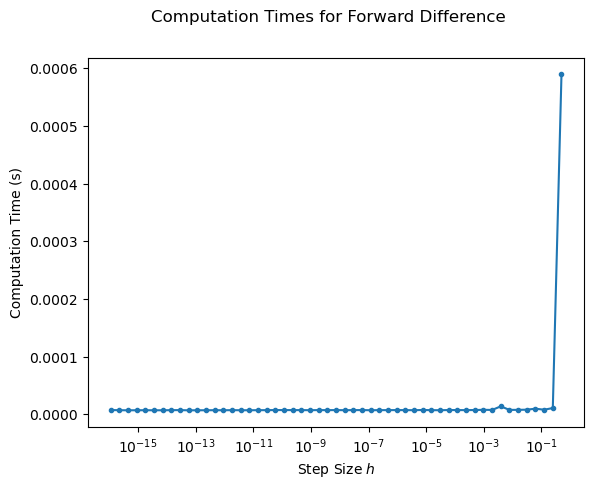

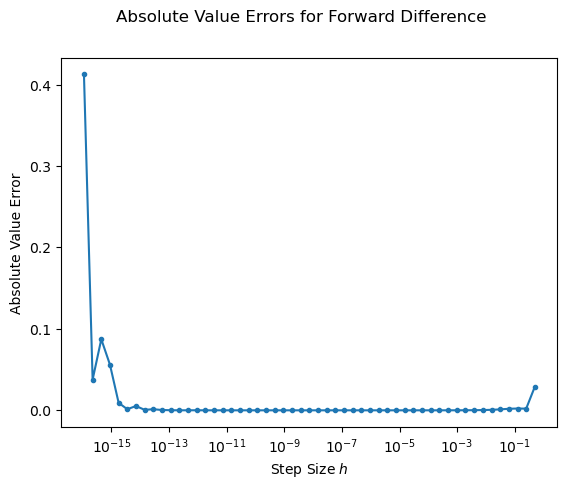

In [45]:
times = []
errors = []
for h in h_vals:
    start = perf_counter()
    forward = (f(x0 + h) - f(x0)) / h
    times.append(perf_counter() - start)
    errors.append(np.abs(forward - fprime_x0_exact))

convergence_plots(h_vals, times, errors, 'Forward Difference', 'Absolute Value')

### Part (iii)

Approximate the derivative $f'(x_0)$ using centered differences 
$$\frac{f(x_0 + h) - f(x_0-h)}{2h}$$
for $ h = 2^{-n}$ ($n = 1, \ldots, 53$).

For each $h$:

1. Perform the centered difference computation.
2. Record the total computation time in the list `times` using `time.perf_counter()` for the start and end times, as before.
3. Record the absolute value of the difference between the approximate value and the actual value computed in part (i), and store it in the list `errors`.

The provided code will help you to calculate convergence rates and to display plots.

In [ ]:
times = []
errors = []
for h in h_vals:
    ...         # TODO: Delete this line and write your code here.

convergence_plots(h_vals, times, errors, 'Centered Difference', 'Absolute Value')

### Part (iv)

Approximate the derivative $f'(x_0)$ using complex step differentiation
$$\frac{\operatorname{Im}(f(x_0 + ih))}{h}$$

For each $h$:

1. Perform the centered difference computation.
2. Record the total computation time in the list `times` using `time.perf_counter()` for the start and end times, as before.
3. Record the absolute value of the difference between the approximate value and the actual value computed in part (i), and store it in the list `errors`.

The provided code will help you to calculate convergence rates and to display plots.

In [ ]:
times = []
errors = []
for h in h_vals:
    ...         # TODO: Delete this line and write your code here.

convergence_plots(h_vals, times, errors, 'Complex Step Differentiation', 'Absolute Value')

### Part (v)

Use the automatic differentiation package `jax` to compute $f'(x_0)$

(Hint: The function `grad`, imported for you up at the top of this file, is the one you'll want to use here. You will need to define a new function for $f$ that uses `jax`'s version of numpy (imported for you at the top as `jnp`) in order to get everything to work. See your Volume 1 Lab for more information on how to use `jax`).

In [ ]:
f = lambda x: 0     # TODO: Replace this with f(x) defined in jnp functions 

...             # TODO: Delete this line and write your code here
                # You only need to do this one once, not for a bunch of h values

## Problem 11.19(iii)

Consider the following simple one-layer ReLu neural network $N_1$ and two-layer ReLu neural network $N_2$, defined for you below for convenience:

In [ ]:
def ReLu(x):
    """Nonlinear activation function for each neuron"""
    return jnp.max(jnp.array([x, 0]))

def F(x1, x2, w11, w12, w21, w22, b11, b12):
    """Activation functions applied to each neuron
    after linear weights/biases applied."""
    return jnp.array([
        ReLu(w11 * x1 + w12 * x2 + b11),
        ReLu(w21 * x1 + w22 * x2 + b12)
    ])

def N1(x1, x2, w01, w02, w11, w12, w21, w22, b0, b11, b12):
    """A simple 1-layer ReLu linear neural network with tuneable weights and biases."""
    w0 = jnp.array([w01, w02])
    return ReLu(
        w0 @ F(x1, x2, w11, w12, w21, w22, b11, b12) + b0
    )

def N2(x1, x2, w01, w02, w11, w12, w21, w22, w31, w32, w41, w42, b0, b11, b12, b21, b22):
    """A simple 2-layer ReLu linear neural network with tuneable weights and biases."""
    F_vals = F(x1, x2, w31, w32, w41, w42, b21, b22)
    return N1(F_vals[0], F_vals[1], w01, w02, w11, w12, w21, w22, b0, b11, b12)

Now, complete the function `N1_w11_der_actual()` by returning the value of the partial derivative with respect to $w_{11}$ of $N_1$, as you should have computed in the written homework on part (ii) of this problem.

In [ ]:
def N1_w11_der_actual(x1, x2, w01, w02, w11, w12, w21, w22, b0, b11, b12):
    """Returns the value of the partial derivative of N1 with respect to w_{11}, 
    as you computed in 11.19(ii) in your written homework."""
    ...         # TODO: Delete this line and write your code here.

Now, use `jax.grad()` with the keyword argument `argnums=4` to take the partial derivative with respect to $w_{11}$ of *both* $N_1$ and $N_2$. 

Then, repeat the following 10 times:

1. Draw each of the following variables from a standard normal distribution $\mathscr{N}(0,1)$:
   
   $$x_1, x_2, w_{01}, w_{02}, w_{11}, w_{12}, w_{21}, w_{22}, w_{31}, w_{32}, w_{41}, w_{42}, b_0, b_{11}, b_{12}, b_{21}, b_{22}$$
2. Evaluate the approximate gradients of $N_1$ and $N_2$ from `jax` with these inputs. Display these to the screen.
3. Evaluate the actual gradient of $N_1$ from `N1_w11_der_actual` with these inputs. Display this to the screen as well.

In [ ]:
# TODO: Use jax.grad() to compute partial derivatives before for loop

# Repeat 10 times 
for i in range(10):
    ...             # TODO: Delete this line and write your code here.

---

IMPORTANT: Please "Restart and Run All" and ensure there are no errors. Then, submit this .ipynb file to Gradescope.